In [1]:
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from lesson_functions import *
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
%matplotlib inline

In [2]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = slice(1,3) # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [450, None] # Min and max in y to search in slide_window()

In [3]:
class FifoForHeatMapAcc:
    maxEl = 20
    def __init__(self):
        self.queue = []
    
    def push(self, el):
        heat = np.copy(el)
        heat[heat>0] = 1
#         plt.imshow(heat)
#         plt.show()
        self.queue.append(heat)
        if len(self.queue) > FifoForHeatMapAcc.maxEl: 
            self.queue = self.queue[-FifoForHeatMapAcc.maxEl:]
        
    
    def heatMap(self, debug=False):
        heatSum = np.copy(self.queue[0])
        cnt = len(self.queue)
        if debug:
            plt.figure(figsize=(10,6))
        for i in range(cnt-1,-1,-1):
            heatSum += self.queue[i] * (i + 1)
            if debug:
                plt.subplot(3,5,cnt-i).imshow(self.queue[i], cmap='binary')
        if debug:
            plt.subplot(3,1,3).imshow(np.clip(heatSum, 0, 255))
            plt.show()
#         print(np.max(heatSum))    
        res = apply_threshold(heatSum, cnt/2*(cnt+1) /3)

        return res
        

In [4]:
def train_classifier():
    print('Reading training data...')
    # Read in cars and notcars
    cars = glob.glob('training/vehicles/*/*.png')
    notcars = glob.glob('training/non-vehicles/*/*.png')
    notcars = notcars[:len(cars)]


    # Reduce the sample size because
    # The quiz evaluator times out after 13s of CPU time
    # sample_size = 500
    # cars = cars[0:sample_size]
    # notcars = notcars[0:sample_size]


    print('Extracting features...')
    t1 = time.time()
    car_features = extract_features(cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

    X = np.vstack((car_features, notcar_features)).astype(np.float64)
    print('Extraction time: {:.1f}s'.format(time.time()-t1))

    print('Training time...')
    for iteration in range(0,1):
        # Fit a per-column scaler
        X_scaler = StandardScaler().fit(X)
        # Apply the scaler to X
        scaled_X = X_scaler.transform(X)

        # Define the labels vector
        y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


        # Split up data into randomized training and test sets
        rand_state = np.random.randint(0, 100)
        X_train, X_test, y_train, y_test = train_test_split(
            scaled_X, y, test_size=0.2, random_state=rand_state)

        print('Using:',orient,'orientations',pix_per_cell,
            'pixels per cell and', cell_per_block,'cells per block', len(X_train[0]), 'features')
        # Use a linear SVC 
        svc = LinearSVC()
        # Check the training time for the SVC


        t=time.time()
        svc.fit(X_train, y_train)
        t2 = time.time()
        # Check the score of the SVC
        print('Test Accuracy of SVC = {:.4f}, time={:.1f}s'.format(svc.score(X_test, y_test), t2-t))
        # Check the prediction time for a single sample
        t=time.time()
    
    return svc, X_scaler

svc, X_scaler = train_classifier()


Reading training data...
Extracting features...
Extraction time: 85.9s
Training time...
Using: 8 orientations 8 pixels per cell and 2 cells per block 3952 features
Test Accuracy of SVC = 0.9858, time=12.4s


In [105]:
for h_orient in [7,10]:
    orient = h_orient
    print('Orientation count: ', orient)
    svc = train_classifier()

Orientation count:  7
Reading training data...
Extracting features...
Extraction time: 70.9s
Training time...
Using: 7 orientations 8 pixels per cell and 2 cells per block 3560 features
Test Accuracy of SVC = 0.9838, time=9.2s
Using: 7 orientations 8 pixels per cell and 2 cells per block 3560 features
Test Accuracy of SVC = 0.9869, time=9.7s
Using: 7 orientations 8 pixels per cell and 2 cells per block 3560 features
Test Accuracy of SVC = 0.9861, time=9.1s
Using: 7 orientations 8 pixels per cell and 2 cells per block 3560 features
Test Accuracy of SVC = 0.9878, time=9.4s
Using: 7 orientations 8 pixels per cell and 2 cells per block 3560 features
Test Accuracy of SVC = 0.9852, time=9.7s
Orientation count:  10
Reading training data...
Extracting features...
Extraction time: 74.7s
Training time...
Using: 10 orientations 8 pixels per cell and 2 cells per block 4736 features
Test Accuracy of SVC = 0.9875, time=17.0s
Using: 10 orientations 8 pixels per cell and 2 cells per block 4736 feature

In [5]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        h = heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]]
        win_size = h.shape[0] * h.shape[1]
#         print('Heat Win size: ',win_size)
        intersect = len(np.nonzero(h)[0])
#         print('Heat intersect {}, relation {:.2f}'.format(intersect, intersect / win_size))
        if intersect / win_size > 0.4:
            h += 3
        else:        
            h += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def labels_to_boxes(labels):
    boxes = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        boxes.append(bbox)

    return boxes
    
    
def heatup_image(image, hot_windows, debug=False):
    # Add heat to each box in box list
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat,hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,11)
    
        
#     plt.imshow(heat)
#     plt.show()
    
    acc_heatmap.push(heat)
    heat = acc_heatmap.heatMap(debug=debug)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
#     plt.imshow(heatmap)
#     plt.show()

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    return labels

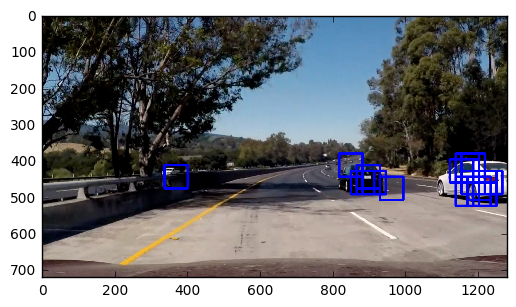

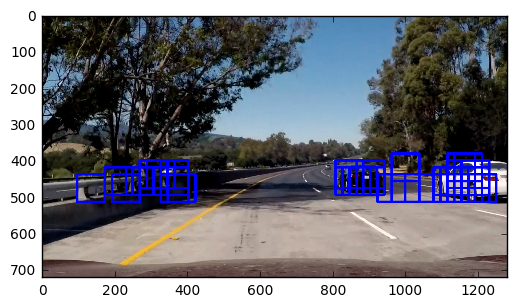

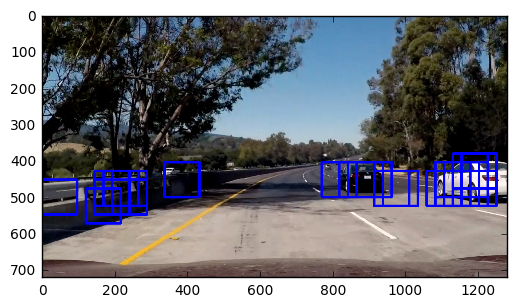

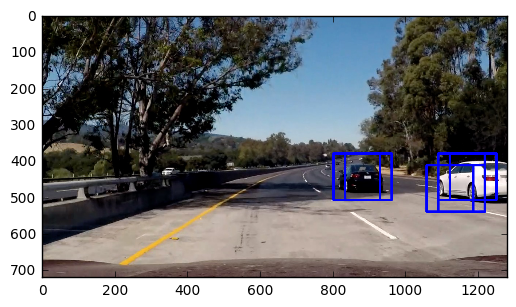

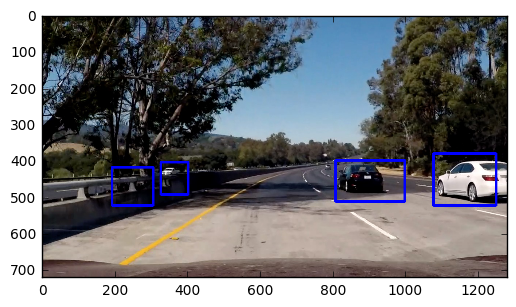

In [6]:

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars_sub(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space):
    t1 = time.time()
    
    draw_img = np.copy(img)
    windows = []
#     img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:].astype(np.float32)/255
    ctrans_tosearch = convert_RGB2(img_tosearch, color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch2.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch2.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
#     hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    
    found_wins = 0
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
#             hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
#             plt.imshow(subimg)
#             plt.show()
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins, bins_range=(0,1))
#             print('Color hist: ', hist_features)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.concatenate((spatial_features, hist_features, hog_features)).reshape(1, -1))    
#             print('Features:', spatial_features)
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.decision_function(test_features)
            
#             print(test_prediction)
            if test_prediction[0] > 0.7:
                test_prediction = 1
            
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            color = (255,0,0) if test_prediction == 1 else (255,255,0)
#             cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),
#                            color,6)
            if test_prediction == 1: 
                found_wins += 1
#                  
                windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    t2 = time.time()
    
#     plt.imshow(draw_img)
#     plt.show()
#     print('Time per search: {:.2f}s'.format(t2-t1))
#     print(found_wins)
    return windows
    
ystart = 380
ystop = 656

img = mpimg.imread('test_images/test5.jpg')


acc_heatmap = FifoForHeatMapAcc()
scale = 1.0
wins00 = find_cars_sub(img, 380, 550, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space)

plt.imshow(draw_boxes(img, wins00))
plt.show()


scale = 1.2
wins0 = find_cars_sub(img, 380, 550, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space)

plt.imshow(draw_boxes(img, wins0))
plt.show()

# out_img = draw_labeled_bboxes(np.copy(img), heatup_image(img, wins))
# plt.imshow(out_img)
# plt.show()

scale = 1.5
wins1 = find_cars_sub(img, 380, 600, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space)

out_img = draw_boxes(img, wins1)
plt.imshow(out_img)
plt.show()


scale = 2
wins2 = find_cars_sub(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space)

out_img = draw_boxes(img, wins2)
plt.imshow(out_img)
plt.show()

out_img = draw_labeled_bboxes(np.copy(img), heatup_image(img, wins00+wins0+wins1+wins2))
plt.imshow(out_img)
plt.show()

# scale = 1.0
# out_img = find_cars_sub(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
# plt.imshow(out_img)

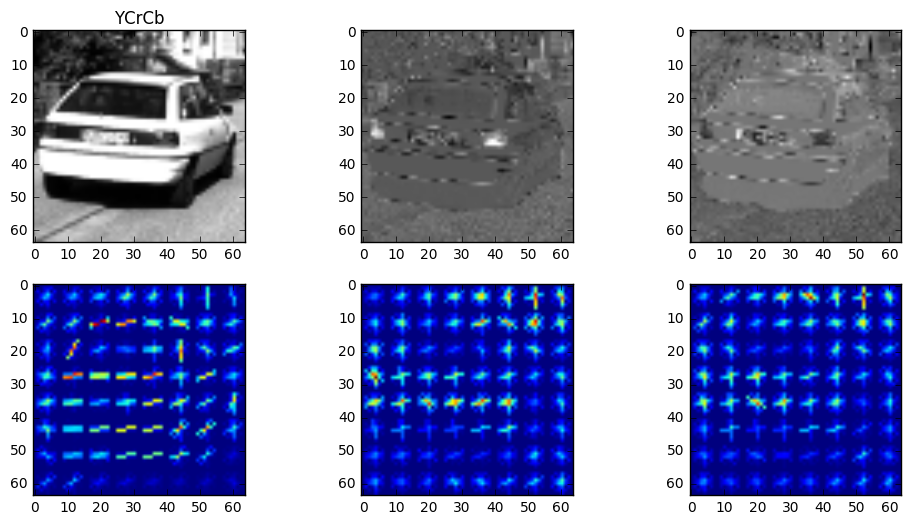

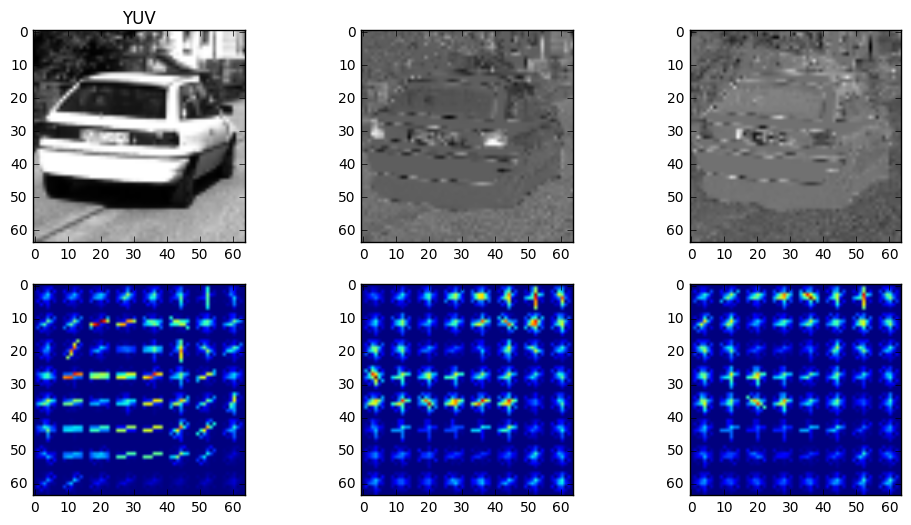

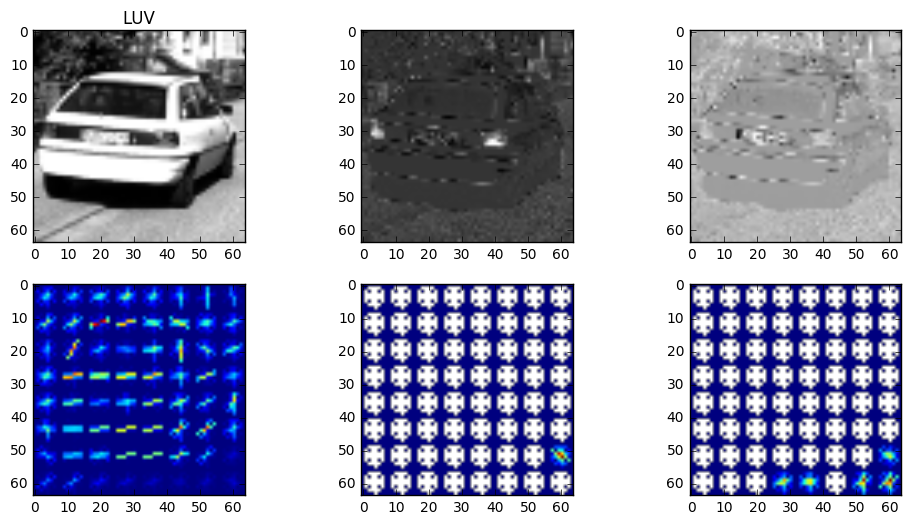

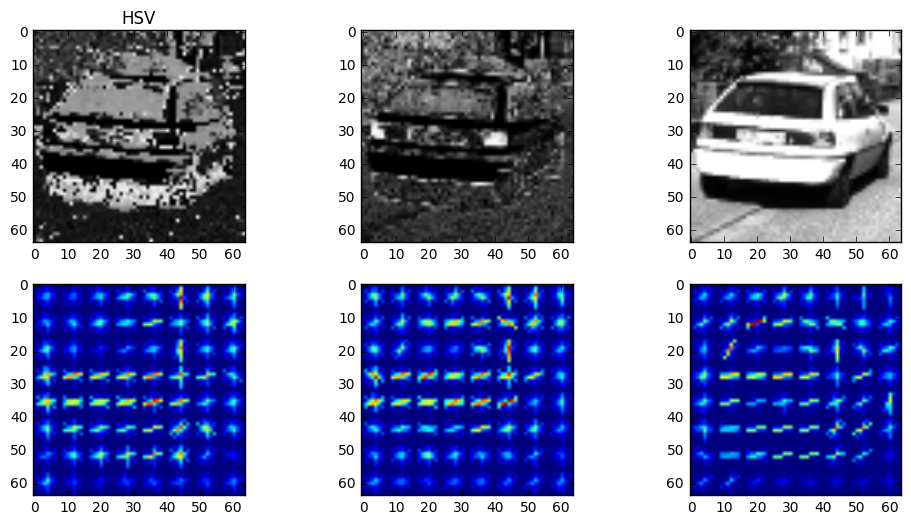

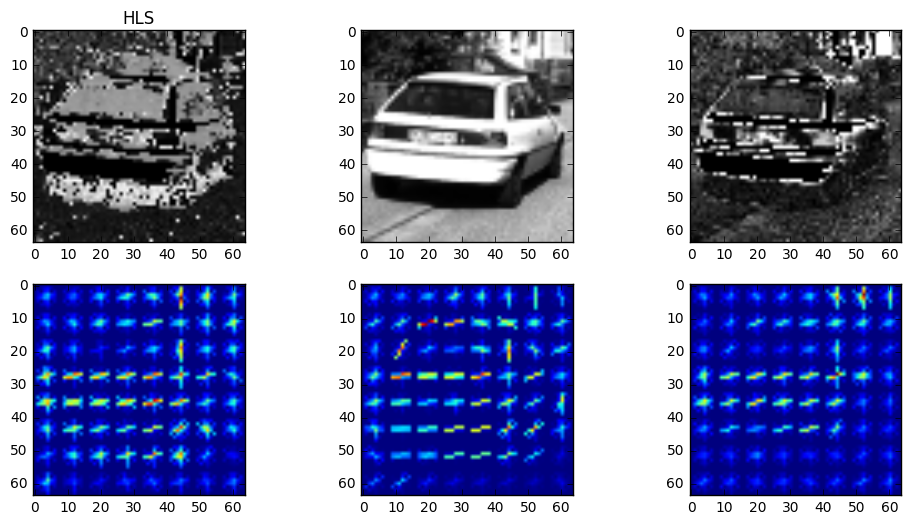

In [86]:
img = mpimg.imread('training/vehicles/KITTI_extracted/301.png')#('test_images/test5.jpg')
# img = mpimg.imread('training/non-vehicles/GTI/image12.png')
def show_color_channels(image, c_map_name):
    plt.figure(figsize=(12,6))
    
    
    cmap = convert_RGB2(image, c_map_name)
    row = 2
    col = cmap.shape[2]
    
    for ch in range(0,col):
        splt = plt.subplot(row, col, ch+1)
        if ch == 0: 
            splt.set_title(c_map_name)
        im = cmap[:,:,ch]
        splt.imshow(im, cmap='gray')
        
        f,hog = get_hog_features(im, orient, pix_per_cell, cell_per_block, vis=True)
        splt = plt.subplot(row, col, ch+4)
        splt.imshow(hog)
    
    plt.show()
    
clst = ['YCrCb','YUV', 'LUV','HSV','HLS']
for color in clst:
    show_color_channels(img, color)


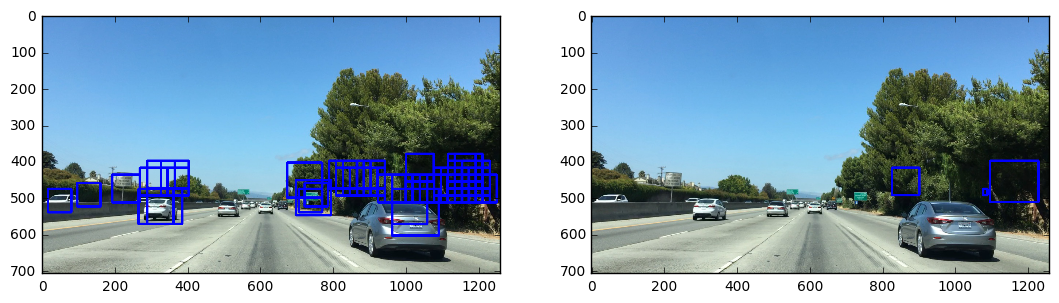

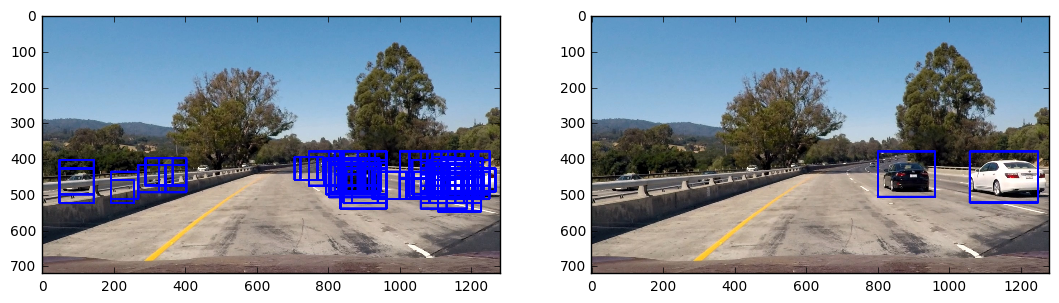

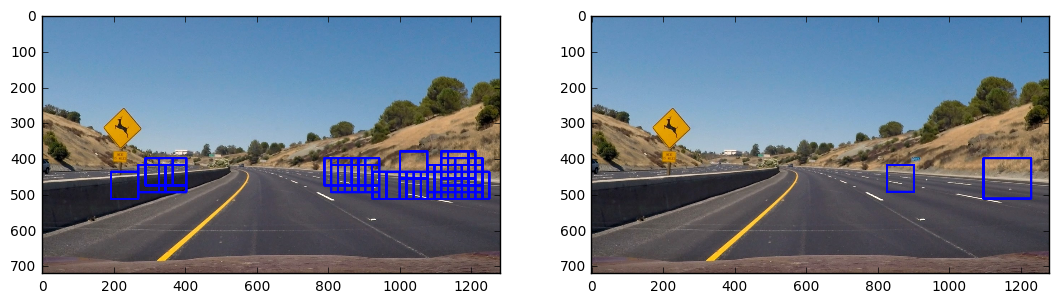

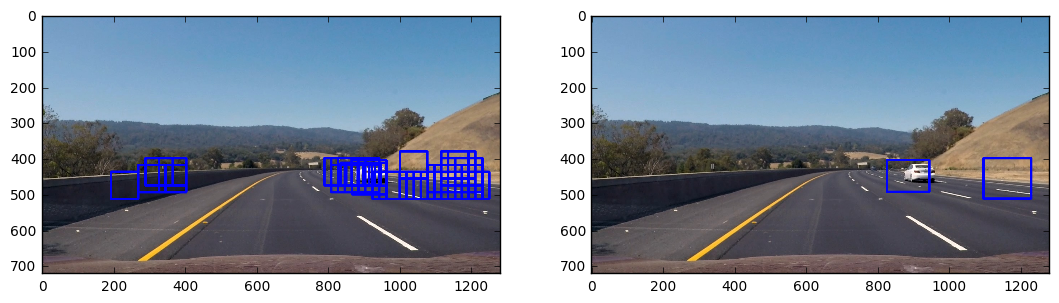

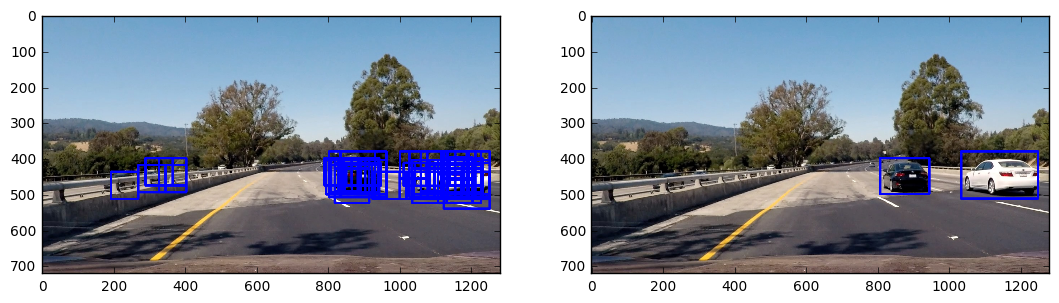

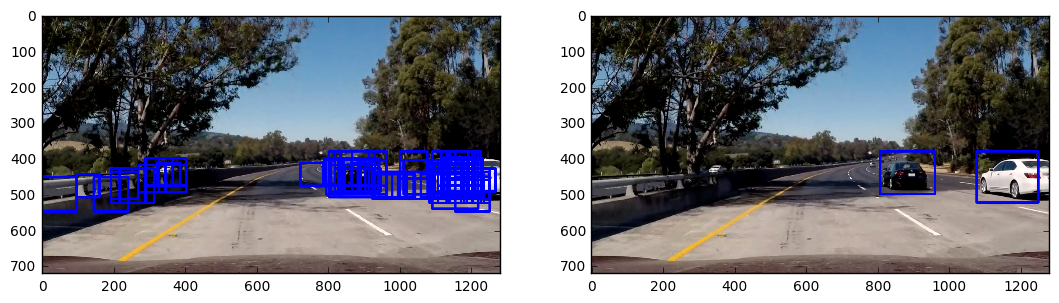

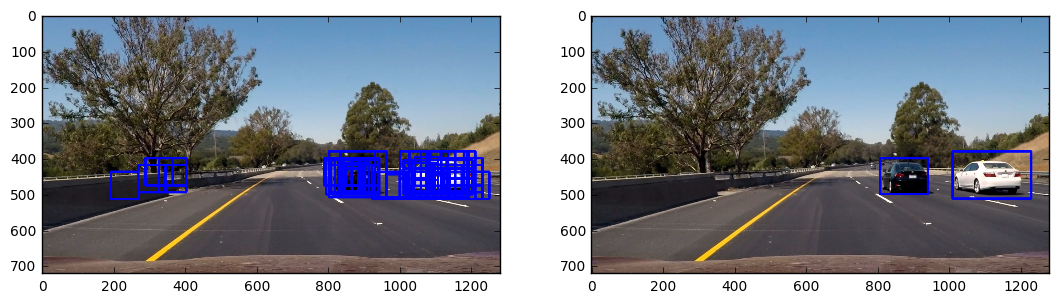

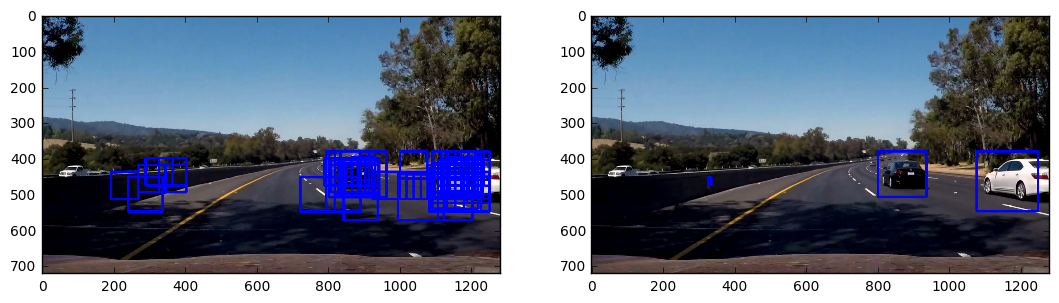

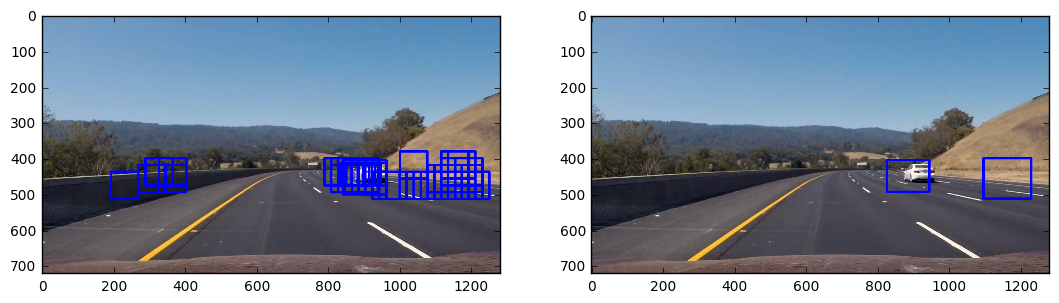

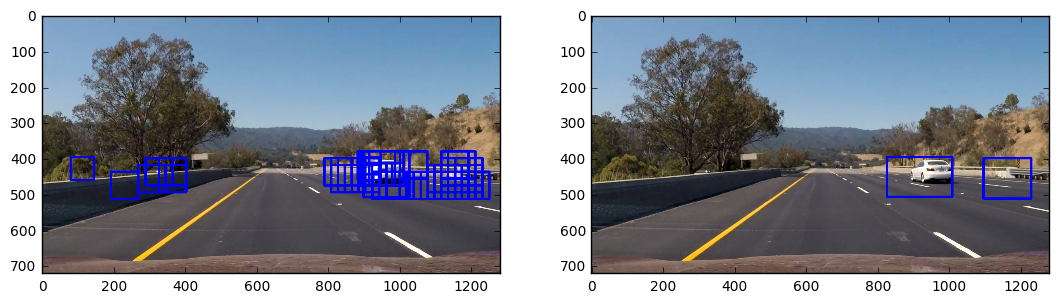

In [12]:
test_images = glob.glob('test_images/*.jpg')
for im_path in test_images:
    im = mpimg.imread(im_path)
#     hot_windows = search_windows(im, windows, svc, X_scaler, color_space=color_space, 
#                         spatial_size=spatial_size, hist_bins=hist_bins, 
#                         orient=orient, pix_per_cell=pix_per_cell, 
#                         cell_per_block=cell_per_block, 
#                         hog_channel=hog_channel, spatial_feat=spatial_feat, 
#                         hist_feat=hist_feat, hog_feat=hog_feat)                       

    draw_image = np.copy(im)
#     window_img = draw_boxes(draw_image, windows, color=(0, 0, 255), thick=6)
#     window_img = draw_boxes(window_img, hot_windows, color=(255, 0, 0), thick=6)
    
#     labels = find_cars(im, windows, svc)
#     window_img = draw_labeled_bboxes(draw_image, labels)

    ystart = 380
    ystop = 680
    scale = 1.2


    acc_heatmap = FifoForHeatMapAcc()
#     scale = 1.2
    wins = find_cars_sub(im, ystart, 570, 1, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space)
    wins += find_cars_sub(img, ystart, 550, 1.2, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space)
    wins += find_cars_sub(im, ystart, 600, 1.5, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space)
    wins += find_cars_sub(im, ystart, ystop, 2, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space)

    window_img = draw_labeled_bboxes(np.copy(im), heatup_image(im, wins))


    plt.figure(figsize=(13,7))
    plt.subplot(121)
    plt.imshow(draw_boxes(im, wins))
    plt.subplot(122).imshow(window_img)
    plt.show()

In [7]:

def find_cars_in_frame(img):
    
    ystart = 380
    ystop = 670
#     scale = 1.2
    wins = find_cars_sub(img, ystart, 550, 1, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space)
    wins += find_cars_sub(img, ystart, 550, 1.2, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space)
    wins += find_cars_sub(img, ystart, 600, 1.5, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space)
    wins += find_cars_sub(img, ystart, ystop, 2, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space)
    
#     plt.imshow(draw_boxes(np.copy(img), wins))
#     plt.show()
    
    window_img = draw_labeled_bboxes(np.copy(img), heatup_image(img, wins, debug=True))

#     labels = find_cars(im, windows, svc, acc_heatmap)
#     window_img = draw_labeled_bboxes(np.copy(im), labels)
#     plt.imshow(window_img)
    return window_img

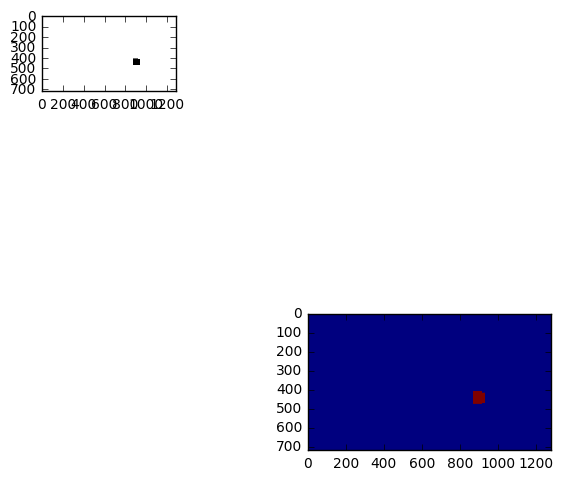

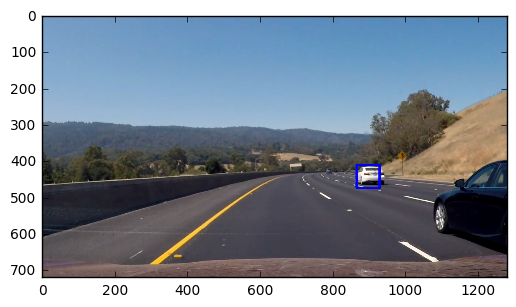

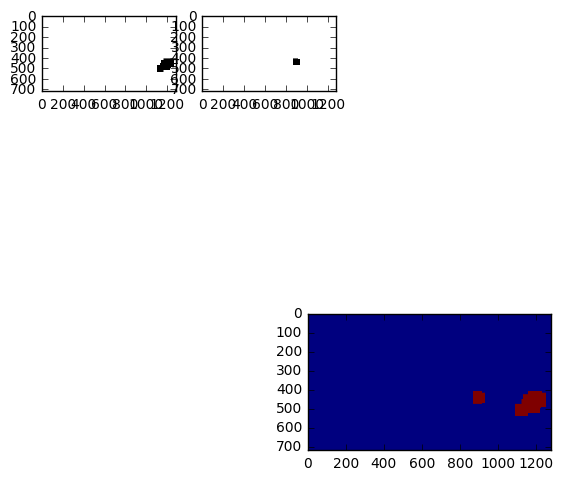

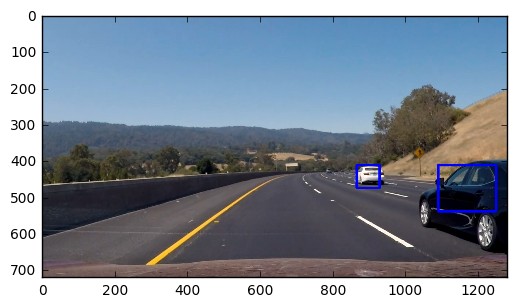

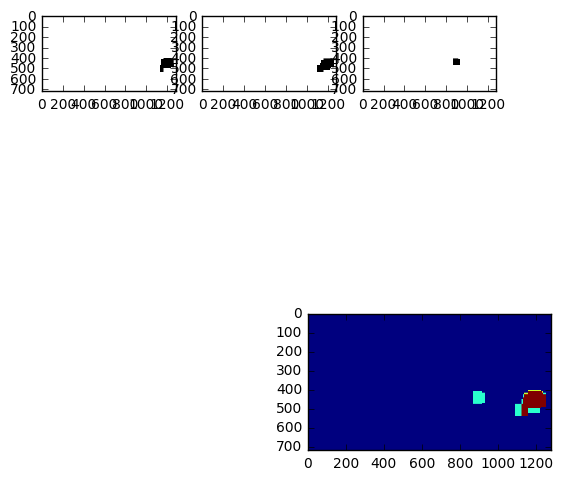

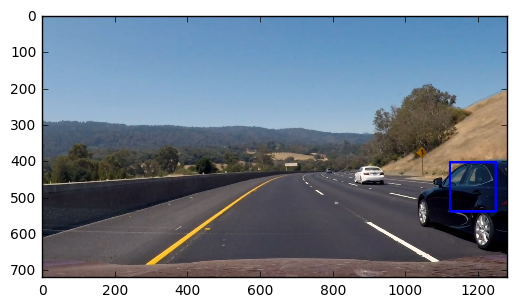

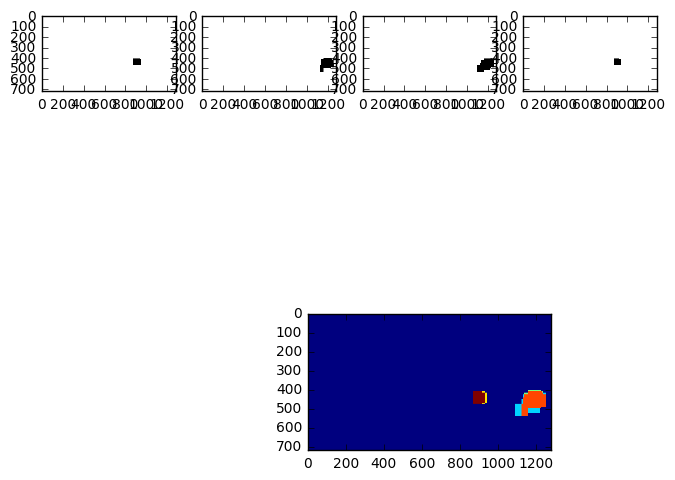

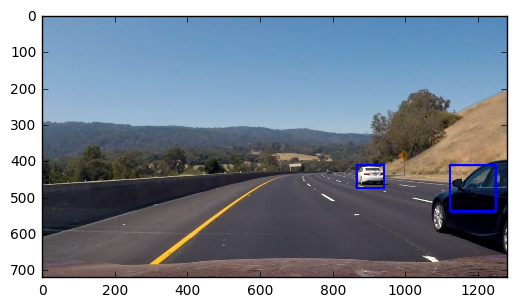

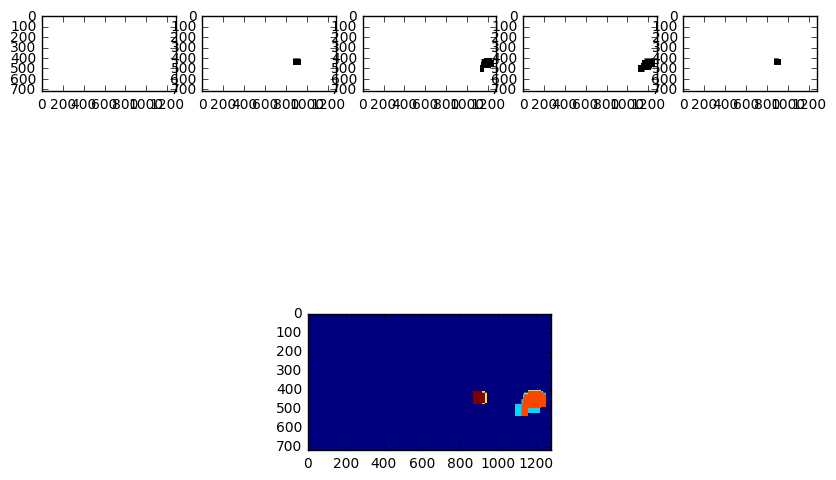

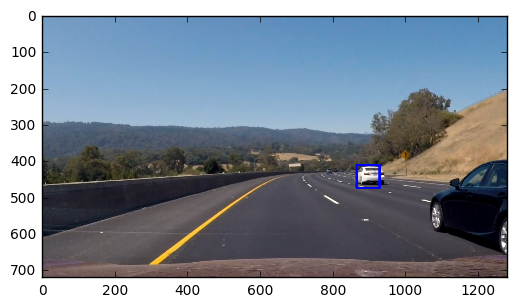

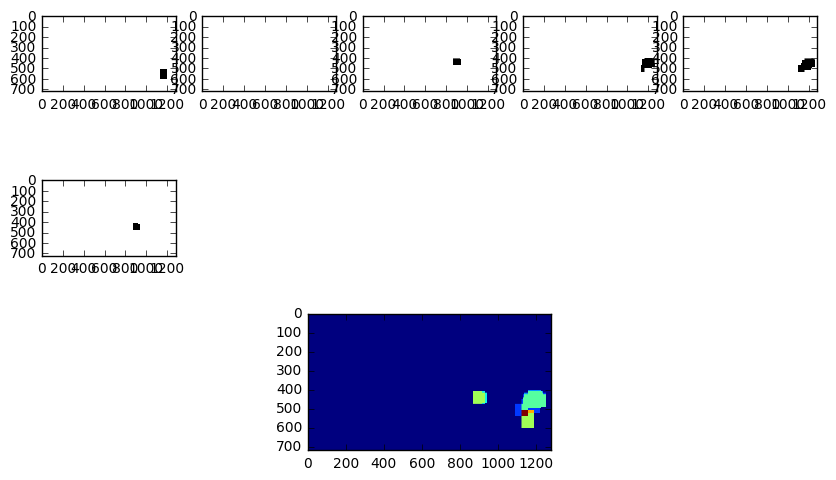

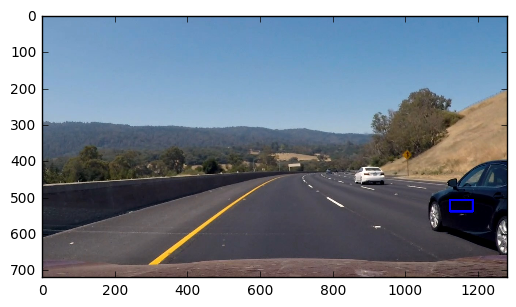

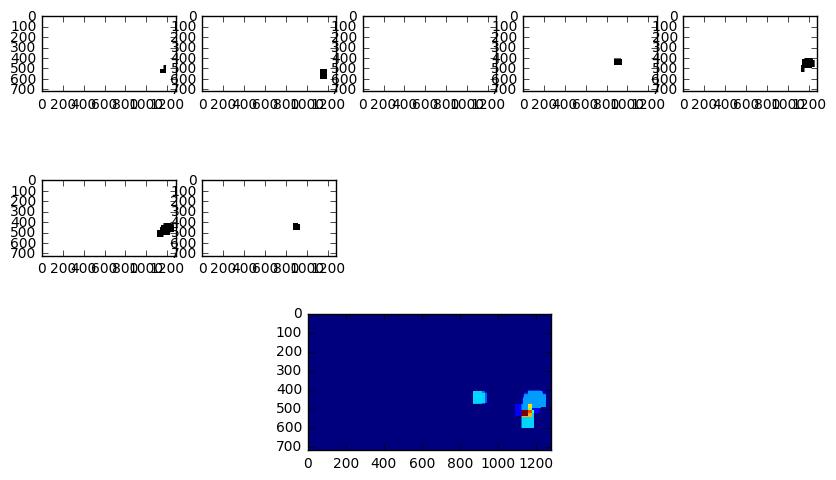

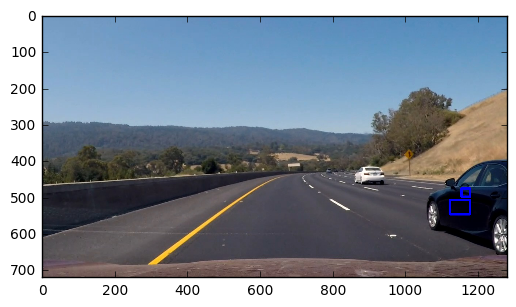

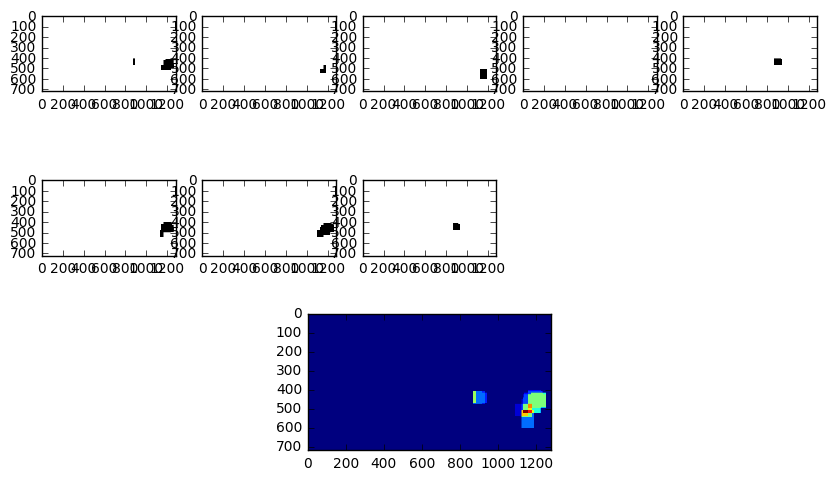

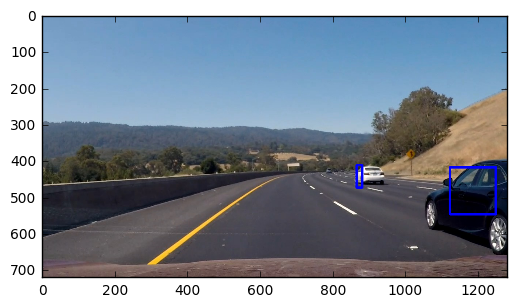

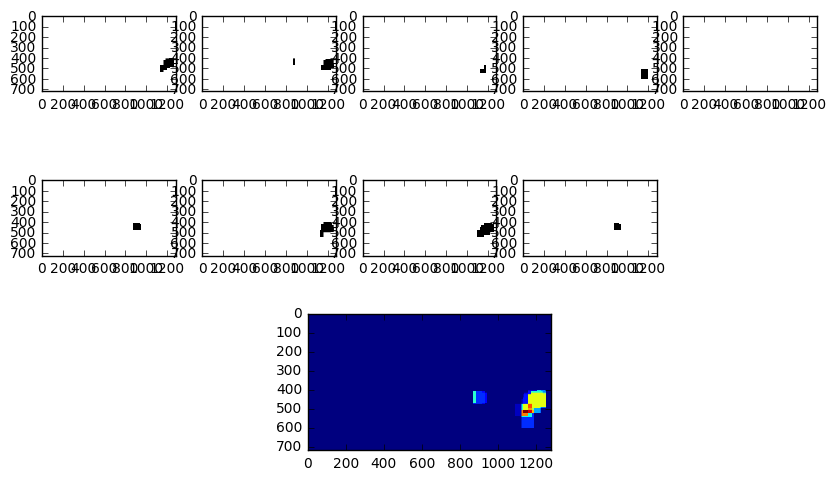

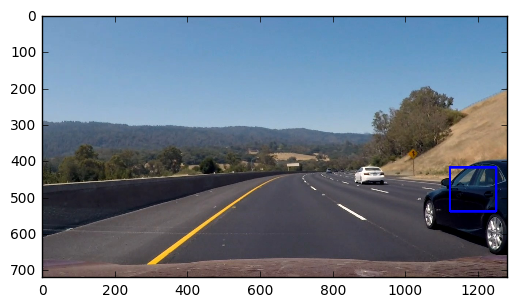

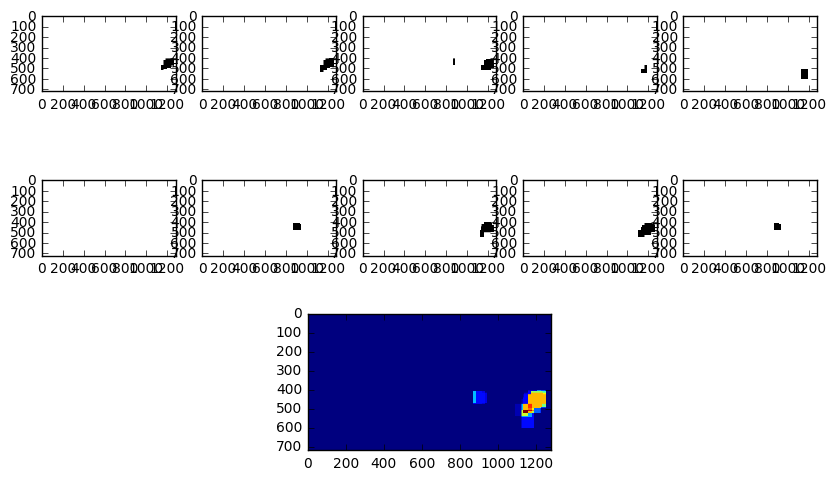

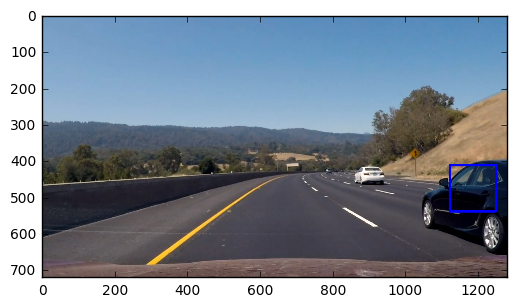

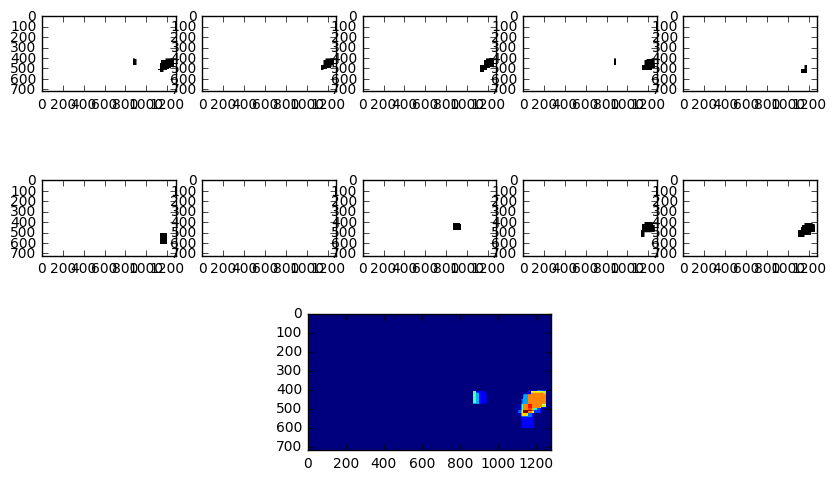

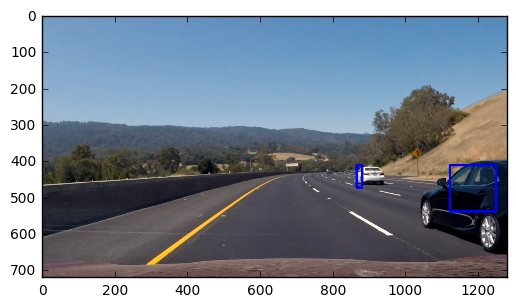

In [8]:
test_images = glob.glob('test_images/sequence/*')
acc_heatmap = FifoForHeatMapAcc() #create a fresh accumulator for image frames
for im_path in test_images:
    im = mpimg.imread(im_path)
    plt.imshow(find_cars_in_frame(im))
    plt.show()

In [81]:
# ln_finder = LaneFinder(mtx, dist)
vid_output = './output_images/vid_out_f3.mp4'
acc_heatmap = FifoForHeatMapAcc()
clip1 = VideoFileClip("./project_video.mp4", audio=False)#.subclip(15, 20)
clip = clip1.fl_image(find_cars_in_frame) 

%time clip.write_videofile(vid_output, audio=False)

[MoviePy] >>>> Building video ./output_images/vid_out_f3.mp4
[MoviePy] Writing video ./output_images/vid_out_f3.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:01<21:42,  1.03s/it]

  0%|          | 2/1261 [00:02<21:46,  1.04s/it]

  0%|          | 3/1261 [00:03<21:23,  1.02s/it]

  0%|          | 4/1261 [00:04<25:23,  1.21s/it]

  0%|          | 5/1261 [00:06<26:47,  1.28s/it]

  0%|          | 6/1261 [00:07<25:16,  1.21s/it]

  1%|          | 7/1261 [00:08<24:05,  1.15s/it]

  1%|          | 8/1261 [00:09<22:59,  1.10s/it]

  1%|          | 9/1261 [00:10<22:22,  1.07s/it]

  1%|          | 10/1261 [00:11<21:49,  1.05s/it]

  1%|          | 11/1261 [00:12<21:52,  1.05s/it]

  1%|          | 12/1261 [00:13<21:35,  1.04s/it]

  1%|          | 13/1261 [00:14<21:22,  1.03s/it]

  1%|          | 14/1261 [00:15<22:09,  1.07s/it]

  1%|          | 15/1261 [00:16<22:07,  1.07s/it]

  1%|▏         | 16/1261 [00:17<21:57,  1.06s/it]

  1%|▏         | 17/1261 [00:18<21:40,  1.05s/it]

  1%|▏         | 18/1261 [00:19<21:32,  1.04s/it]

  2%|▏         | 19/1261 [00:20<21:39,  1.05s/i

[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/vid_out_f3.mp4 

CPU times: user 22min 16s, sys: 1min 11s, total: 23min 28s
Wall time: 23min 52s
